**합성곱 신경망을 사용한 컴퓨터 비전**

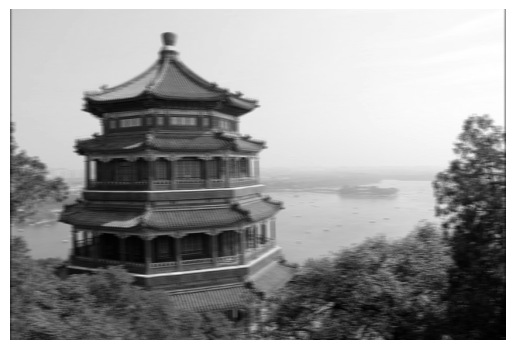

In [28]:
from sklearn.datasets import load_sample_image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 샘플 이미지를 로드한다.
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
# 2개의 필터를 만든다.
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직선
filters[3, :, :, 1] = 1  # 수평선
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')
plt.imshow(outputs[0, :, :, 1], cmap='gray')  # 첫 번째 이미지의 두 번째 특성맵을 그린다.
plt.axis('off')
plt.show()